In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import re

import spacy
from spacy import displacy

import rich
from rich.console import Console
from rich import print
from rich.theme import Theme

from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

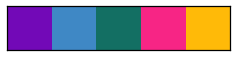

In [2]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)

custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold blue"
})

console = Console(theme=custom_theme)

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
train_df.loc[0, 'excerpt']

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [6]:
excerpt1 = train_df['excerpt'].min()

print("Before preprocessing: ")
print(excerpt1)

e = re.sub("[^a-zA-Z]", " ", excerpt1)
e = e.lower()
        
e = nltk.word_tokenize(e)
        
e = [word for word in e if not word in set(stopwords.words("english"))]
        
lemma = nltk.WordNetLemmatizer()
e = [lemma.lemmatize(word) for word in e]
e=" ".join(e)
print("After preprocessing: ")
print(e)

Before preprocessing:

"'Morning, Jeeves," I said.
"Good morning, sir," said Jeeves. He put the good old cup of tea softly on the table by my 
bed, and I took a refreshing sip. Just right, as usual. Not too hot, not too sweet, not too 
weak, not too strong, not too much milk, and not a drop spilled in the saucer. A most amazing
cove, Jeeves. So dashed competent in every respect. I've said it before, and I'll say it 
again. I mean to say, take just one small instance. Every other valet I've ever had used to 
barge into my room in the morning while I was still asleep, causing much misery: but Jeeves 
seems to know when I'm awake by a sort of telepathy. He always floats in with the cup exactly
two minutes after I come to life. Makes a deuce of a lot of difference to a fellow's day.
"How's the weather, Jeeves?" 
"Exceptionally clement, sir."
"Anything in the papers?"
"Some slight friction threatening in the Balkans, sir. Otherwise, nothing."

After preprocessing:

morning jeeves said good morning sir said jeeves put good old cup tea softly table bed took 
refreshing sip right usual hot sweet weak strong much milk drop spilled saucer amazing cove 
jeeves dashed competent every respect said say mean say take one small instance every valet 
ever used barge room morning still asleep causing much misery jeeves seems know awake sort 
telepathy always float cup exactly two minute come life make deuce lot difference fellow day 
weather jeeves exceptionally clement sir anything paper slight friction threatening balkan 
sir otherwise nothing

In [7]:
def preprocess(data):
    excerpt_processed=[]
    for e in data['excerpt']:
        
        # find alphabets
        e = re.sub("[^a-zA-Z]", " ", e)
        
        # convert to lower case
        e = e.lower()
        
        # tokenize words
        e = nltk.word_tokenize(e)
        
        # remove stopwords
        e = [word for word in e if not word in set(stopwords.words("english"))]
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e=" ".join(e)
        
        excerpt_processed.append(e)
        
    return excerpt_processed 

In [11]:
train_df["excerpt_preprocessed"] = preprocess(train_df)
test_df["excerpt_preprocessed"] = preprocess(test_df)

#train_df.to_csv("train_excerpt_preprocessed.csv")
#test_df.to_csv("test_excerpt_preprocessed.csv")

In [12]:
def training(model, X_train, y_train, X_test, y_test, model_name):
    t1 = time.time()
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        model,
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    
    t2 = time.time()
    training_time = t2-t1 
    
    console.print("--- Model:", model_name,"---", style='warning')
    console.print("MSE: ", MSE, style='danger')
    console.print("Training time:", training_time, style='danger')

ridge = Ridge(fit_intercept = True, normalize = False)
lr = LinearRegression()
m = [ridge,lr]
mn = ["Ridge Regression","Linear Regression"]

X = train_df["excerpt_preprocessed"]
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i in range(0,len(m)):
    training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

--- Model: Ridge Regression ---

MSE:  0.5408408615292747

Training time: 0.21265506744384766

--- Model: Linear Regression ---

MSE:  0.5971163067912272

Training time: 0.24559903144836426

In [13]:
def training_all(model,X,y):
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        model,
    )
    model.fit(X, y)
    y_pred = model.predict(test_df["excerpt_preprocessed"])
    
    return y_pred

In [14]:
test_pred = training_all(lr,X,y)
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = test_pred
predictions.to_csv("submission.csv", index=False)
predictions

,id,target
0,c0f722661,-1.321194
1,f0953f0a5,-0.620439
2,0df072751,-0.542019
3,04caf4e0c,-2.311644
4,0e63f8bea,-1.603932
5,12537fe78,-0.425918
6,965e592c0,-0.087885


In [38]:
test_pred = training_all(ridge,X,y)
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = test_pred
predictions.to_csv("submission.csv", index=False)
predictions

,id,target
0,c0f722661,-1.216041
1,f0953f0a5,-0.496235
2,0df072751,-0.818767
3,04caf4e0c,-1.945870
4,0e63f8bea,-1.511735
5,12537fe78,-0.524104
6,965e592c0,-0.043354
